# Application of Data Analysis and Unsupervised Machine Learning
# Project: Clustering Grocery Items 
   ##                                   --- How to find the items that can be most possibly bought together？

## **Background:**

For many online grocery stroe, there are often two many items. So, one important thing is how to organize the items in categories so that they can be easily found by the customers. Herein, this project is to look at user purchase history and create items that are most likely to be bought together. The detailed goals are:


1). Find the curstomer who bought the most items overall in his/her lifetime;


2). for each tiem, the customer who bought that product the most


3). Create clusters of products that have the highest probability of being bought together(each item can belong to just one cluster).

In [1]:
# import basic libraries, some libraries will be imported when needed later
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Table of Contents
  1. [Read Data](#read_data)
  2. [Build User-item-counts matrx](#build)
  3. [Question 1](#question1)
  4. [Question 2](#question2)
  5. [Build item-item matrx](#Build)
  6. [Question 3: Create Clusters](#question3:createclusters)

<a id='read_data'></a>
## Read Data

In [3]:
# read data and use the item_id as the index
item_to_id = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/9. grocery/item_to_id.csv', index_col = 'Item_id')

# sort the data according to the item-id
item_to_id.sort_index(inplace = True)
item_to_id.head()

,Item_name
Item_id,
1,sugar
2,lettuce
3,pet items
4,baby items
5,waffles


In [4]:
# Check the basi information of item_to_id
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [4]:
# Load another table
purchase_history = pd.read_csv('C:/Users/xiaoj/Desktop/CS/collection of data science-take home challenges/Data/9. grocery/purchase_history.csv')
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [34]:
purchase_history[purchase_history['user_id']==269335]

,user_id,id
12030,269335,"2,1,42,11,9,39,37,19,38,23"
21971,269335,"46,14,2,24,4,18,9,6,10,41,28,42,44,23"
25662,269335,"13,47,21,2,9,23,36,48,17,42,10,37,6"
31105,269335,"37,13,6,2,18,3,42,9,38,35,24,36,39"
34939,269335,"44,3,11,22,2,10,36,25,30,40,28,20,41"
38512,269335,"17,12,21,37,34,36,43,26,28"


In [5]:
# Check the basi information of purchase_history
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


<a id='build'></a>
## Build user_item_counts  matrix

In [6]:
from collections import Counter

# Built a function to calculate how many times the user bought one item
def item_counts(data):
    # transfer the item id to string
    # Splits the string in the Series and put them together
    item_ids = data['id'].str.split(',').sum()
    
    # to calculate the occurences of all items in a list, there are 2 methods: 
    # Method 1. list comprehension: [[x, data['id'].count(x)] for x in data['id']]
    # return pd.Series(dict((id, item_ids.count(int(id))) for id in item_ids))
    # Here I will choose method 2 since it is more convenient 
    
    # Method 2. From collections import Counter, Counter(int(id)) for id in item_ids
    return pd.Series(Counter(int(id) for id in item_ids))

In [9]:
# calculate how many times per user bought one item
user_item_counts = purchase_history.groupby('user_id').apply(item_counts).unstack(fill_value=0)
user_item_counts.head(5)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


<a id='question1'></a>
## Question 1
### The customer who bought the most items overall in his/her lifetime

In [38]:
user_item_total = user_item_counts.sum(axis=1)
user_item_total.sort_values(ascending=False).head()

user_id
269335    72
367872    70
599172    64
397623    64
377284    63
dtype: int64

In [39]:
# This is another way to calculate the user_id of max item-counts
user_item_total = user_item_counts.sum(axis=1)

print(user_item_total.idxmax())
print(user_item_total.max())

269335
72


The ID of customer who bought the most items overall in her/his life is 269335, and she/he bought 72 items.

<a id='question2'></a>
## Question 2
For each item, who is the customer who bought that product the most

In [110]:
# to find the customer who bought the product most, I just need to find the maxium value of each column in user_item_counts
user_item_counts.head()

Item_ID,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [111]:
# to find the customer id who buy the max products
max_user = user_item_counts.apply(lambda a:pd.Series([a.idxmax(), a.max()],index=['max_user_ID', 'max_count']))
max_user

Item_ID,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
max_user_ID,31625,31625,154960,5289,217277,334664,175865,151926,269335,618914,...,599172,38872,133355,80215,996380,31625,1198106,1218645,384935,335841
max_count,4,5,4,3,3,4,3,3,4,4,...,5,4,4,4,4,4,5,4,4,3


In [112]:
# transpost the table and rename the index
max_user = max_user.T
max_user.index.name = 'Item_ID'
max_user

,max_user_ID,max_count
Item_ID,,
1,31625,4
2,31625,5
3,154960,4
4,5289,3
5,217277,3
6,334664,4
7,175865,3
8,151926,3
9,269335,4


In [113]:
# join the two tabel together and get the item name
final = pd.concat([item_to_id, max_user], axis=1)
final

,Item_name,max_user_ID,max_count
1,sugar,31625,4
2,lettuce,31625,5
3,pet items,154960,4
4,baby items,5289,3
5,waffles,217277,3
6,poultry,334664,4
7,sandwich bags,175865,3
8,butter,151926,3
9,soda,269335,4
10,carrots,618914,4


<a id='Build'></a>
## Build the item-item similarity matrix

In [114]:
# normalize the user_item_counts
from sklearn.preprocessing import normalize
normalized_user_item_counts= normalize(user_item_counts, axis=0)

# build the item-item similarity matrx
items_similarity = normalized_user_item_counts.T.dot(normalized_user_item_counts)

# transfer the iterms_similarity to be DataFrame
items_similarity = pd.DataFrame(items_similarity, index=user_item_counts.columns, columns=user_item_counts.columns)
items_similarity.shape

(48, 48)

In [115]:
items_similarity.head()

Item_ID,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Item_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


<a id='question3:createclusters'></a>
## Question 3 : Create Clusters

In [305]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [306]:
# Here I will combine PCA and K-means clustering to cluster all the items. PCA is used to reduce unnecessary features and decrease noice

# create a PCA
pca = PCA()
pca = pca.fit(items_similarity)

Text(0, 0.5, 'variance %')

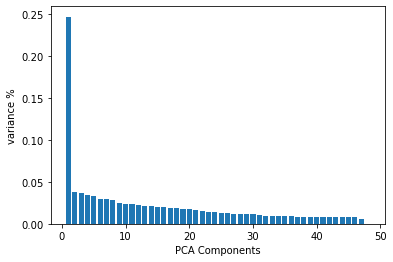

In [307]:
# Plot the explained variances with different PCA components
plt.bar(range(1,pca.n_components_+1), pca.explained_variance_ratio_)
plt.xlabel('PCA Components')
plt.ylabel('variance %')

To find the most suitable PCA components, figure above will usually be used to find the best PCA components which is thought to located on the point where variance changed most. Herein although the second one decreased steeply, I will choose the first 5 since it is not a good idea to choose pca component to be 1.

In [254]:
# use the best components to optimize the previous data
pca = PCA(n_components =5)
pca.fit(items_similarity)
items_pca=pca.transform(items_similarity)

In [258]:
# After using PCA to dimensionality reduction, I will use K-means clustering to cluster items 
# find the clusters of products that have the highest probability of being bought together

# create two list, one is used to store the sum of squre distances of samples to the closest cluster center
inertias = []
# silhouette is used to store the metric score to evaluate the performance of different k-cluster 
silhouettes = []

for i in range(2, 40):
    kmeans_pca = KMeans(n_clusters=i, random_state=42)
    kmeans_pca = kmeans_pca.fit(items_pca)
    label = kmeans_pca.predict(items_pca)
    # add the sum of squares distances of samples to the colosest cluster center
    inertias.append(kmeans_pca.inertia_)
    # add the Silhouette score
    silhouettes.append(silhouette_score(items_pca, label))

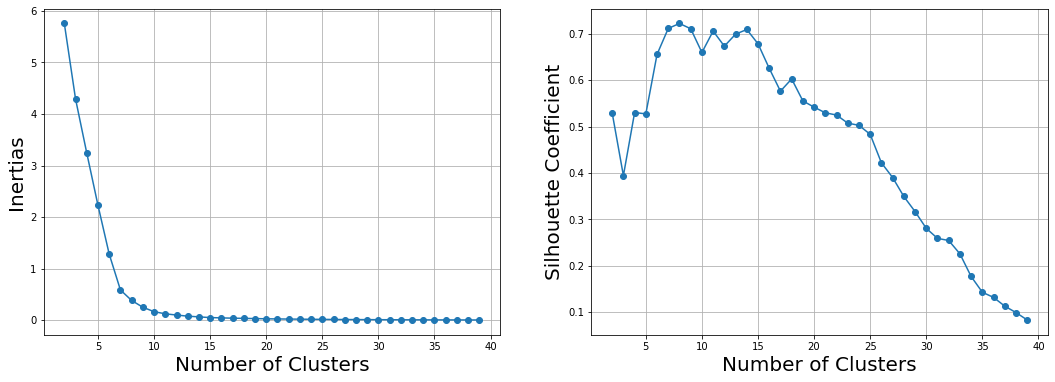

In [308]:
# Plot the square-sum against the number of clusters, and use elbow method to find best k
fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(range(2,40),inertias,marker='o')
ax[0].set_xlabel('Number of Clusters',size=20)
ax[0].set_ylabel('Inertias',size=20)
ax[0].grid(True)

# plot silhouette score against the number of clusters to evaluate the performance of different clusters(the higher, the better)
ax[1].plot(range(2,40),silhouettes, marker='o')
ax[1].set_xlabel('Number of Clusters',size=20)
ax[1].set_ylabel('Silhouette Coefficient',size=20)
ax[1].grid(True)

It can be found that both inertias (elbow method) and silhouette scores(the highest value) showed that most optimized k is 8.

In [263]:
# rebuild k-means model with the optimized cluster number 
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans = kmeans.fit(items_pca)
label = kmeans.predict(items_pca)

In [310]:
# build the frame to store item_id and its corresponding label
df = pd.DataFrame({'Item_id': list(range(1,49)),'label':label})

# combine the new frame with the previous table to show the item name instead of item id
df = pd.merge(left = df, right=item_to_id, on='Item_id', how='left')

# print each label and what kinds of items are labelled the same
for i in range(0,8):
    print(i,'\t', list(df[df['label']==i]['Item_name']))

0 	 ['sugar', 'poultry', 'soda', 'carrots', 'bagels', 'beef', 'tea', 'tortillas', 'dinner rolls', 'juice', 'sandwich loaves', 'cucumbers', 'coffee', 'broccoli', 'cauliflower', 'pork']
1 	 ['sandwich bags', 'aluminum foil', 'paper towels', 'toilet paper']
2 	 ['baby items', 'waffles', 'cereals', 'flour', 'pasta']
3 	 ['shampoo', 'shaving cream', 'hand soap', 'soap']
4 	 ['butter', 'eggs', 'milk', 'cheeses', 'yogurt']
5 	 ['grapefruit', 'cherries', 'apples', 'berries', 'bananas']
6 	 ['pet items', 'laundry detergent', 'frozen vegetables', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'ice cream', 'ketchup']
7 	 ['lettuce']
